In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import glob
from scipy import stats
import pingouin as pg
import xarray as xr
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle
import dataframe_image as dfi
import sys
sys.path.insert(0, '/home/disk/p/aodhan/cf_physical_parameters_correlations/TTLVariability')
import tool_box

colors = np.array([(22,98,248), (48,141,250), (71,172,251), (100,201,252), (129,222,253),(162,240,254), (215,249,253), (255,255,255), 
                   (255,255,255), (255,249,217), (247,236,155), (254,221,128), (254,202,100), (255,173,71), (252,142,42), (255,101,15)])/255
custom_cmap = LinearSegmentedColormap.from_list('cmap', colors)

def cf_profile_finder(cf_prof_maps):
    cf_prof_maps_ = np.sort(cf_prof_maps)
    profile_cf = np.array([np.load(cf_prof_maps_[yr])[0] for yr in range(len(cf_prof_maps_))])
    empty_prof_map = np.empty(np.shape(profile_cf[:5]))
    empty_prof_map[:] = np.NaN
    profile_cf = np.concatenate((empty_prof_map, profile_cf), axis=0)
    profile_cf = np.reshape(profile_cf, (16,12,36,221))
    profile_cf[10,1] = np.nanmean([profile_cf[10,0], profile_cf[10,2]], axis=0)
    profile_cf_anoms = profile_cf - np.nanmean(profile_cf, axis=0)
    return(profile_cf_anoms)

# Pull in timeseries
project_path = '/home/disk/p/aodhan/cf_physical_parameters_correlations'
cpts, cpzs, total_cf, temp_profs, profiles_cf, allTCFCalendarMaps, mjo_index, enso_index, qbo_index, bdc_mf, bdc_eddy, wv_calendar = tool_box.starter()

# Pull in other CF data
all_cf_prof_maps = np.sort(glob.glob(project_path + '/aerosol_cloud_distinctions/cfmaps/GlobalZMMonthlyCFProfiles_strataerosolremoved_polarcloudsremoved_*.npy'))
profile_all_cf_anoms = cf_profile_finder(all_cf_prof_maps)


/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice


In [18]:
# Get annual mean tropopause data
project_path = '/home/disk/p/aodhan/cf_physical_parameters_correlations'
cpz_maps_zm_annual_mean = np.load(project_path + '/tempmaps/cpz_maps_zm_annual_mean.npy')
lrz_maps_zm_annual_mean = np.load(project_path + '/tempmaps/lrz_maps_zm_annual_mean.npy')

# Water vapor data needs to be re-binned
wv_calendar_raw = np.load(project_path + '/fileCreators/h2o_calendar_raw.npy')
#wv_cal_tropics_utls = wv_calendar_raw
wv_cal_tropics_utls = wv_calendar_raw - np.nanmean(wv_calendar_raw, axis=0)
wv_cal_tropics_utls_ts_lagged = np.reshape(wv_cal_tropics_utls, (17*12,55,45))[1:-11]
h2o_anoms_zm_ts = np.reshape(wv_cal_tropics_utls_ts_lagged, (192,55,45))
h2o_anoms_zm_ts = np.swapaxes(h2o_anoms_zm_ts, 1, 2)



/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == "__main__":


In [12]:
def vert_temp_gradient(data_calendar):
    data_calendar = np.array(data_calendar)
    t_1 = data_calendar[:,:,1:]
    t_2 = data_calendar[:,:,:-1]
    dt_dz = (t_1 - t_2)/0.1 # K/km
    dt_dz_1 = dt_dz[:,:,1:]
    dt_dz_2 = dt_dz[:,:,:-1]
    dt_dz_new = np.nanmean([dt_dz_1, dt_dz_2], axis=0)
    empty = np.empty(np.shape(data_calendar[:,:,0]))
    empty[:] = np.NaN
    dt_dz_new = np.insert(dt_dz_new, 348, empty, axis=2)
    dt_dz_new = np.insert(dt_dz_new, 0, empty, axis=2)
    smoothed_dtdz_cal = []
    for mon in range(len(dt_dz_new)):
        global_smoothed = []
        for lat in range(len(dt_dz_new[0,:])):
            data = dt_dz_new[mon,lat]
            rolling_mean = pd.Series(data).rolling(10).mean()
            global_smoothed.append(rolling_mean)
        smoothed_dtdz_cal.append(global_smoothed)
    return(np.array(smoothed_dtdz_cal))

RO_monthly_mean_maps = np.nanmean(temp_profs, axis=3)
RO_anomaly_maps = RO_monthly_mean_maps - np.nanmean(RO_monthly_mean_maps, axis=0)
temp_anomaly_ts = np.reshape(RO_anomaly_maps, (np.shape(RO_anomaly_maps)[0]*np.shape(RO_anomaly_maps)[1], 
                                             np.shape(RO_anomaly_maps)[2], np.shape(RO_anomaly_maps)[3]))
dtdz_anomaly_ts = vert_temp_gradient(temp_anomaly_ts)


/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


In [13]:
TempProf_anoms_ts = temp_anomaly_ts
dtdzProf_anoms_ts = dtdz_anomaly_ts
for lat_idx in range(0,36):
    for mon_idx in range(5, 192):
        for h_idx in range(350):
            if np.isnan(TempProf_anoms_ts[mon_idx, lat_idx, h_idx]):
                TempProf_anoms_ts[mon_idx, lat_idx, h_idx] = np.nanmean([TempProf_anoms_ts[mon_idx+1, lat_idx, h_idx], 
                                                                   TempProf_anoms_ts[mon_idx-1, lat_idx, h_idx]], axis=0)
                dtdzProf_anoms_ts[mon_idx, lat_idx, h_idx] = np.nanmean([dtdzProf_anoms_ts[mon_idx+1, lat_idx, h_idx], 
                                                                   dtdzProf_anoms_ts[mon_idx-1, lat_idx, h_idx]], axis=0)
temp_profs_ = np.array(TempProf_anoms_ts)
dtdz_profs = np.array(dtdzProf_anoms_ts)
temp_profs_ = np.nanmean(np.reshape(temp_profs_, (192,36,2,350)), axis=2)
dtdz_profs = np.nanmean(np.reshape(dtdz_profs, (192,36,2,350)), axis=2)


/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  


In [14]:
# Large Scale Dynamics w/leads
mjo = np.load('/home/disk/p/aodhan/large_scale_dynamics/mjo_vpm_pc2_index.npy')[-187:]
qbo = np.load(project_path + '/fileCreators/u50hPa_10NS_1979_2021.npy')[-189:-2]
T500 = np.load(project_path + '/fileCreators/T500_15NS_500hPa_1979_2021.npy')[-187:]

enso = pd.read_csv('/home/disk/p/aodhan/GNSSRSC-2023/Data/meiv2_adjusted.data', sep="    ", header=None)
enso_calendar = [list(enso.iloc[i].values) for i in range(0,len(enso))][27:43]
enso = np.ravel(enso_calendar)[-190:-3]

# get total mass and then calculate upwelling
def z_(p):
    p0 = 1000 # hPa (reference pressure)
    H = 7000 # m (scale height)
    z = H*np.log(p0/p)
    return z
scale_height_relative = z_(100)/7000
density = 1.255 #kg/m3
density_at_100hPa = np.exp(-1*scale_height_relative)*1.255
a = 6.378e6
area_between_lats = 2*np.pi*(a**2)*(np.sin(np.deg2rad(15)) - np.sin(np.deg2rad(-15)))
total_mass = density_at_100hPa*area_between_lats
w_star = np.load('/home/disk/p/aodhan/cf_physical_parameters_correlations/fileCreators/wstar100_15NS.npy')
w_star_cal = w_star.reshape(16,12)*total_mass
w_star_anoms = w_star_cal - np.nanmean(w_star_cal, axis=0)
w_star_anoms_ts = w_star_anoms.ravel()
w_star_anoms_ts = w_star_anoms_ts[-187:]
raw_upwelling_mf_100hPa = w_star_anoms_ts
upwelling_mf_100hPa = w_star_anoms_ts
Trop_upwelling = w_star_anoms_ts

BDC_EHF = np.load('/home/disk/p/aodhan/large_scale_dynamics/BDC_100hPa_EHF_3mrm.npy')[-192:]
bdc_ehf_cal = BDC_EHF.reshape(16,12)
bdc_ehf_cal_anoms = bdc_ehf_cal - np.nanmean(bdc_ehf_cal, axis=0)
bdc_ehf_cal_anoms_ts = bdc_ehf_cal_anoms.ravel()
bdc = bdc_ehf_cal_anoms_ts[-187:]

# also pull in CPT
cpts_TTL = cpts#[:,:,24:48,:]
cpts_anomalies = tool_box.anomaly_finder(cpts_TTL)
cpt_tropical_mean = tool_box.tropical_average(cpts_anomalies)
cpt_ts = cpt_tropical_mean.ravel()[5:]

/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)
/home/disk/p/aodhan/cf_physical_parameters_correlations/TTLVariability/tool_box.py:138: RuntimeWarning: invalid value encountered in true_divide
  tropical_mean = np.nansum(tropical_data_reshaped, axis=2)/np.nansum(tropical_weights_reshaped, axis=2)


In [15]:
def trend_finder(array_of_data):
    time = np.arange(200.6, 202.2, 1/120)[5:] # time (in decades)
    trends_and_significance = []
    all_detrended_timeseries = []
    idx = 0
    for ts in array_of_data:
        idx += 1
        regression = stats.linregress(time, ts)

        # find residual timeseries
        ts_trend = regression[0]
        temp_linear_trend = regression[1] + ts_trend*time
        errors = ts - temp_linear_trend

        # find degrees of freedom with autocorrelation
        N = len(ts)
        r1_autocorrelation = stats.pearsonr(ts[1:], ts[:-1])[0]
        r2_autocorrelation = stats.pearsonr(time[1:], time[:-1])[0]
        
        N_star = N*((1-r1_autocorrelation)/
                    (1+r1_autocorrelation))
        # find squared error in x and y
        sum_squared_error_res = np.sum(np.square(errors))
        sum_squared_error_times = np.sum(np.square(time - np.nanmean(time)))
        simga_slope_squared = (1/N_star)*(sum_squared_error_res/sum_squared_error_times)
        sigma_slope = np.sqrt(simga_slope_squared)

        # get critical t value
        tcrit = stats.t.ppf(1-0.025, N_star)

        # test for significance
        b_below = ts_trend - tcrit*sigma_slope
        b_above = ts_trend + tcrit*sigma_slope

        if b_above*b_below > 0:
            significant = 1
        else:
            significant = 0

        trends_and_significance.append([ts_trend, significant])
        detrended_timeseries = ts - temp_linear_trend
        all_detrended_timeseries.append(detrended_timeseries)

    return(all_detrended_timeseries, trends_and_significance)

predictors_and_target = np.array([cpt_ts, qbo, bdc, Trop_upwelling, T500])
all_detrended_timeseries, trends_and_significance = trend_finder(predictors_and_target)
cpt, qbo, bdc, up100, T500 = all_detrended_timeseries

In [16]:


upwelling_df = pd.DataFrame(np.transpose([qbo, bdc, up100, T500]), columns=['QBO', 'BDC', 'UP100', 'T500'])
upwelling_MLR = pg.linear_regression(upwelling_df[['QBO', 'BDC', 'T500']], upwelling_df['UP100'], relimp=True)
qbo_enso_bdc_fit = upwelling_MLR.coef[0] + upwelling_df['QBO']*upwelling_MLR.coef[1] + upwelling_df['BDC']*upwelling_MLR.coef[2] + upwelling_df['T500']*upwelling_MLR.coef[3] 
up100 = up100 - qbo_enso_bdc_fit

In [19]:
def ZeroCorrPolarStratClouds(cf_rmap, cf_sigmap):
    """cloud profile data at lats>50 and lats<-50 have anomalous cloud fraction data.
       This for-loop sets all data above the tropopause in these regions to zero"""
    for lat_idx in [0,1,2,3,4,5,6,7,28,29,30,31,32,33,34,35]:
        LRT_z = lrz_maps_zm_annual_mean[lat_idx] # height of lapse-rate trop at given lat
        LRT_z_index = int(np.around(LRT_z, 1)*10 + 20)
        cf_rmap[LRT_z_index:, lat_idx] = 0
        cf_sigmap[LRT_z_index:, lat_idx] = 0
    return(cf_rmap, cf_sigmap)

def press2alt(press):
    H = 7
    altitude = -1*H*np.log(press/1000)
    return altitude
def alt2pres(altitude):
    H = 7 
    press = 1000*np.exp(-1*(altitude/H))
    return press

def profile_correlator(pc, varmap):
    pc = pc/np.nanstd(pc)
    r_map = []
    sig_map = []
    for x in range(0, len(varmap[0,:])):
        r_x = []
        sig_x = []
        for y in range(len(varmap[0,0,:])):        
            temp_series = varmap[:,x,y]
            temp_series_no_nans = temp_series[~np.isnan(temp_series)]
            pc_non_nans = pc[~np.isnan(temp_series)]
            try:
                N = len(temp_series)
                r = stats.pearsonr(temp_series_no_nans[:], pc_non_nans[:])[0]
                r1_autocorrelation = stats.pearsonr(temp_series_no_nans[1:], temp_series_no_nans[:-1])[0]
                r2_autocorrelation = stats.pearsonr(pc_non_nans[1:], pc_non_nans[:-1])[0]
                N_star = N*((1-r1_autocorrelation*r2_autocorrelation)/
                            (1+r1_autocorrelation*r2_autocorrelation))
                tcrit = stats.t.ppf(1-0.025, N_star)
                t = (r*np.sqrt(N_star - 2))/(np.sqrt(1 - r**2))
                if abs(t) - tcrit > 0:
                    significant = 1
                else:
                    significant = 0
            except:
                r = np.NaN
                significant = 0
            r_x.append(r)
            sig_x.append(significant)
        r_map.append(r_x)
        sig_map.append(sig_x)
    return(np.transpose(r_map), np.transpose(sig_map))

# LSD and CF data
cf_profs = np.reshape(profile_all_cf_anoms, (192, 36, 221))[5:]
qbo_cf_rmap, qbo_cf_sigmap = profile_correlator(qbo, cf_profs)
bdc_cf_rmap, bdc_cf_sigmap = profile_correlator(bdc, cf_profs)
bdc1ml_cf_rmap, bdc1ml_cf_sigmap = profile_correlator(up100, cf_profs)
cpt_cf_rmap, cpt_cf_sigmap = profile_correlator(cpt, cf_profs)
enso_cf_rmap, enso_cf_sigmap = profile_correlator(T500, cf_profs)

qbo_cf_rmap, qbo_cf_sigmap = ZeroCorrPolarStratClouds(qbo_cf_rmap, qbo_cf_sigmap)
bdc_cf_rmap, bdc_cf_sigmap = ZeroCorrPolarStratClouds(bdc_cf_rmap, bdc_cf_sigmap)
bdc1ml_cf_rmap, bdc1ml_cf_sigmap = ZeroCorrPolarStratClouds(bdc1ml_cf_rmap, bdc1ml_cf_sigmap)
cpt_cf_rmap, cpt_cf_sigmap = ZeroCorrPolarStratClouds(cpt_cf_rmap, cpt_cf_sigmap)
enso_cf_rmap, enso_cf_sigmap = ZeroCorrPolarStratClouds(enso_cf_rmap, enso_cf_sigmap)

# LSD and Temp data
qbo_temp_rmap, qbo_temp_sigmap = profile_correlator(qbo, temp_profs_[5:])
bdc_temp_rmap, bdc_temp_sigmap = profile_correlator(bdc, temp_profs_[5:])
bdc1ml_temp_rmap, bdc1ml_temp_sigmap = profile_correlator(up100, temp_profs_[5:])
cpt_temp_rmap, cpt_temp_sigmap = profile_correlator(cpt, temp_profs_[5:])
enso_temp_rmap, enso_temp_sigmap = profile_correlator(T500, temp_profs_[5:])

# LSD and dtdz data
qbo_dtdz_rmap, qbo_dtdz_sigmap = profile_correlator(qbo, dtdz_profs[5:])
bdc_dtdz_rmap, bdc_dtdz_sigmap = profile_correlator(bdc, dtdz_profs[5:])
bdc1ml_dtdz_rmap, bdc1ml_dtdz_sigmap = profile_correlator(up100, dtdz_profs[5:])
cpt_dtdz_rmap, cpt_dtdz_sigmap = profile_correlator(cpt, dtdz_profs[5:])
enso_dtdz_rmap, enso_dtdz_sigmap = profile_correlator(T500, dtdz_profs[5:])

# LSD and WV data
qbo_wv_rmap, qbo_wv_sigmap = profile_correlator(qbo, h2o_anoms_zm_ts[5:])
bdc_wv_rmap, bdc_wv_sigmap = profile_correlator(bdc, h2o_anoms_zm_ts[5:])
bdc1ml_wv_rmap, bdc1ml_wv_sigmap = profile_correlator(up100, h2o_anoms_zm_ts[5:])
cpt_wv_rmap, cpt_wv_sigmap = profile_correlator(cpt, h2o_anoms_zm_ts[5:])
enso_wv_rmap, enso_wv_sigmap = profile_correlator(T500, h2o_anoms_zm_ts[5:])

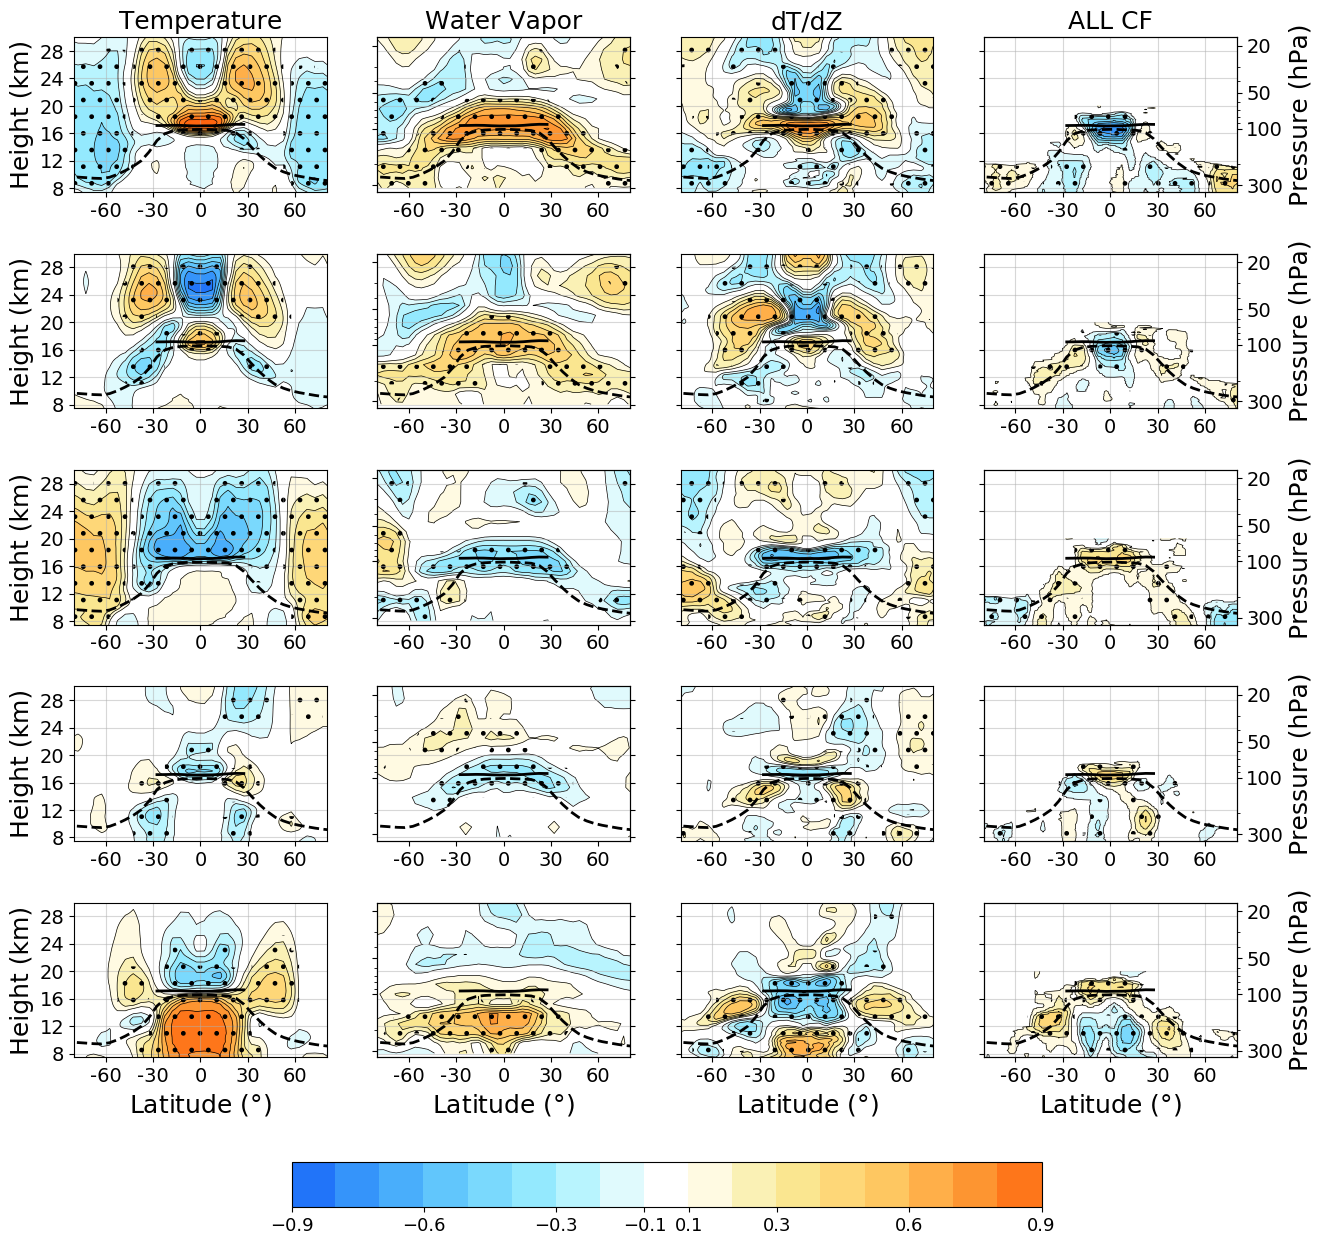

In [22]:
fig, axs = plt.subplots(5,4, figsize=(15,15))
levels = np.array([-.9,-.8,-.7,-.6,-.5,-.4,-.3,-.2,-.1,.1,.2,.3,.4,.5,.6,.7,.8,.9])
pressure_levels = [1000.0, 825.4042, 681.29205, 562.3413, 464.15887, 
                 383.11868, 316.22775, 261.01572, 215.44347, 177.82794, 
                 146.77992, 121.15276, 100.0, 82.54042, 68.1292, 56.23413, 
                 46.41589, 38.311867, 31.622776, 26.101572, 21.544348, 
                 17.782795, 14.677993, 12.115276, 10.0, 8.254042, 6.8129206, 
                 5.623413, 4.6415887, 3.8311868, 3.1622777, 2.6101573, 2.1544347, 
                 1.7782794, 1.4677993, 1.2115277, 1.0, 0.68129206, 0.4641589, 
                 0.31622776, 0.21544346, 0.14677992, 0.1, 0.046415888, 0.021544347, 
                 0.01, 0.004641589, 0.0021544348, 0.001, 0.0004641589, 0.00021544346, 
                 1e-04, 4.6415887e-05, 2.1544347e-05, 1e-05]
pressures_as_alts = press2alt(np.array(pressure_levels))
alts_as_pressures = alt2pres(np.linspace(0,20, 201))
cm = custom_cmap

#row_labels = ['CPT \n\nHeight (km)', 'QBO\n\nHeight (km)', 'BDC\n\nHeight (km)', 'UP100\n\nHeight (km)', 'T500\n\nHeight (km)']
row_labels = ['Height (km)', 'Height (km)', 'Height (km)', 'Height (km)', 'Height (km)']
row_labels_twiny = ['Pressure (hPa)', 'Pressure (hPa)', 'Pressure (hPa)', 'Pressure (hPa)', 'Pressure (hPa)']
col_labels = ["Temperature", "Water Vapor", "dT/dZ", "ALL CF"]
corr_maps = np.array(
            [[cpt_temp_rmap, cpt_wv_rmap, cpt_dtdz_rmap, cpt_cf_rmap],
             [qbo_temp_rmap, qbo_wv_rmap, qbo_dtdz_rmap, qbo_cf_rmap], 
             [bdc_temp_rmap, bdc_wv_rmap, bdc_dtdz_rmap, bdc_cf_rmap],
             [bdc1ml_temp_rmap, bdc1ml_wv_rmap, bdc1ml_dtdz_rmap, bdc1ml_cf_rmap],
             [enso_temp_rmap, enso_wv_rmap, enso_dtdz_rmap, enso_cf_rmap]])
sig_maps = np.array(
            [[cpt_temp_sigmap, cpt_wv_sigmap, cpt_dtdz_sigmap, cpt_cf_sigmap], 
             [qbo_temp_sigmap, qbo_wv_sigmap, qbo_dtdz_sigmap, qbo_cf_sigmap], 
             [bdc_temp_sigmap, bdc_wv_sigmap, bdc_dtdz_sigmap, bdc_cf_sigmap],
             [bdc1ml_temp_sigmap, bdc1ml_wv_sigmap, bdc1ml_dtdz_sigmap, bdc1ml_cf_sigmap],
             [enso_temp_sigmap, enso_wv_sigmap, enso_dtdz_sigmap, enso_cf_sigmap]])

for row in range(5):
    axs[row,0].set_ylabel(row_labels[row], fontsize=18)
    for col in [0,2,3]:
        if col != 3:
            axs[0,col].set_title(col_labels[col], fontsize=18)
            axs[row,col].contourf(np.linspace(-87.5,87.5,36), np.linspace(5,40,350), corr_maps[row,col], levels=levels, cmap=cm, extend='both')
            axs[row,col].contour(np.linspace(-87.5,87.5,36), np.linspace(5,40,350), corr_maps[row,col], levels=levels, colors='black', 
                                 linewidths=0.5, linestyles=np.where(levels >= 0, "-", "-"))
            axs[row,col].contourf(np.linspace(-87.5,87.5,36), np.linspace(5,40,350), sig_maps[row,col], levels=[-1, 0, 1], colors='none', hatches=[None,'.'])
        if col == 3:
            axs[0,col].set_title(col_labels[col], fontsize=18)
            cf_im = axs[row,col].contourf(np.linspace(-87.5,87.5,36), np.linspace(0,20,201), corr_maps[row,col][:201], levels=levels, cmap=cm)
            axs[row,col].contour(np.linspace(-87.5,87.5,36), np.linspace(0,20,201), corr_maps[row,col][:201], levels=levels, colors='black', linewidths=0.5, 
                          linestyles=np.where(levels >= 0, "-", "-"))
            axs[row,col].contourf(np.linspace(-87.5,87.5,36), np.linspace(0,20,201), sig_maps[row,col][:201], levels=[-1, 0, 1], colors='none', hatches=[None,'.'])
            naned_cyclic_cal = corr_maps[row,col][:201].copy()
            naned_cyclic_cal[:] = np.NaN
            ax2 = axs[row,col].twinx()
            ax2.contourf(np.linspace(-87.5,87.5,36), alts_as_pressures, naned_cyclic_cal)
            ax2.set_ylim(ax2.get_ylim()[::-1])
            ax2.set_yscale('log')
            ax2.set_ylim(342,17)
            ax2.set_yticks([300, 100, 50, 20])
            ax2.set_yticklabels(labels=['300','100','50','20'], fontsize=14)
            ax2.set_ylabel(row_labels_twiny[row], fontsize=18)
        
        axs[row, col].plot(np.linspace(-87.5,87.5,36), lrz_maps_zm_annual_mean, color='black', linewidth=2, linestyle='dashed')
        axs[row, col].plot(np.linspace(-87.5,87.5,36)[12:24], cpz_maps_zm_annual_mean[12:24], color='black', linewidth=2)
        axs[row, col].set_ylim(7.5,30)
        axs[row, col].set_xlim(-80,80)
        axs[row, col].grid(alpha=0.5)
    for col in [1]:
        axs[0,col].set_title(col_labels[col], fontsize=18)
        axs[row,col].contourf(np.linspace(-88,88,45), pressure_levels, corr_maps[row,col], levels=levels, cmap=cm)
        axs[row,col].contour(np.linspace(-88,88,45), pressure_levels, corr_maps[row,col], levels=levels, colors='black', linewidths=0.5, 
                          linestyles=np.where(levels >= 0, "-", "-"))
        axs[row,col].contourf(np.linspace(-88,88,45), pressure_levels, sig_maps[row,col], levels=[-1, 0, 1], colors='none', hatches=[None,'.'])
        axs[row,col].set_ylim(axs[row,col].get_ylim()[::-1])
        axs[row,col].set_yscale('log')
        #axs[row,col].yaxis.tick_right()
        axs[row,col].set_ylim(342,17)
        axs[row,col].set_yticks([300, 100, 50, 20])
        axs[row,col].set_yticklabels(labels=[' ',' ',' ',' '], fontsize=14)
        axs[row, col].set_xlim(-80,80)
        #axs[row, col].grid(alpha=0.5)
        naned_cyclic_cal = corr_maps[row,col].copy()
        naned_cyclic_cal[:] = np.NaN
        ax2 = axs[row,col].twinx()
        ax2.contourf(np.linspace(-88,88,45), pressures_as_alts, naned_cyclic_cal)
        #ax2.yaxis.tick_left()
        ax2.grid(alpha=0.5)
        ax2.set_ylim(7.5,30)
        ax2.plot(np.linspace(-87.5,87.5,36), lrz_maps_zm_annual_mean, color='black', linewidth=2, linestyle='dashed')
        ax2.plot(np.linspace(-87.5,87.5,36)[12:24], cpz_maps_zm_annual_mean[12:24], color='black', linewidth=2)
        ax2.set_yticks([8,12,16,20,24,28])
        ax2.set_yticklabels(labels=[' ',' ',' ',' ',' ',' '], fontsize=14)

for col in [0,1,2,3]:
    for row in range(5):
        axs[1,col].set_xticks([-60,-30,0,30,60])
        axs[row,col].set_xticks([-60,-30,0,30,60])
        if col == 0:
            axs[row,col].set_yticks([8,12,16,20,24,28])
            axs[row,col].set_yticklabels(labels=['8','12','16','20','24','28'], fontsize=14)
            ax2.set_yticklabels(labels=[' ',' ',' ',' ',' ',' '], fontsize=14)
        elif col == 3:
            axs[row,col].set_yticks([8,12,16,20,24,28])
            axs[row,col].set_yticklabels(labels=[' ',' ',' ',' ',' ',' '], fontsize=14)
            #ax2.set_yticklabels(labels=['150','100',' ',' ','70',' ', '50'], fontsize=14)
        elif col == 1:
            ax2.set_yticklabels(labels=[' ',' ',' ',' ',' ',' '], fontsize=14)
        else:
            axs[row,col].set_yticks([8,12,16,20,24,28])
            axs[row,col].set_yticklabels(labels=[' ',' ',' ',' ',' ',' '], fontsize=14)
            ax2.set_yticklabels(labels=[' ',' ',' ',' ',' ',' '], fontsize=14)
        axs[row,col].set_xticklabels(labels=['-60','-30','0','30','60'], fontsize=14)
        axs[4,col].set_xlabel('Latitude ($\degree$)', fontsize=18)

plt.subplots_adjust(bottom=0.2,
                    hspace=0.4)
cbar_cf = fig.add_axes([0.27, 0.1, 0.5, 0.03])
fig.colorbar(cf_im, cax=cbar_cf, orientation='horizontal', ticks=[-.9, -.6,-.3,-.1,.1, .3,.6,.9])
cbar_cf.tick_params(labelsize=13) 